In [1]:
import re
import ast
from bs4 import BeautifulSoup
import os

def keep_assignments(code_snippet):
    # Regex to match variable assignments. This pattern assumes variable names are valid Python identifiers
    # and captures typical assignment statements, excluding those that might appear in comments or strings.
    pattern = r'^\s*[a-zA-Z_][a-zA-Z0-9_]*\s*=\s*.+'

    # Filter and keep only lines with variable assignments
    assignments = [line for line in code_snippet.split('\n') if re.match(pattern, line)]

    # Join the filtered lines back into a string
    return "\n".join(assignments)

# This function will be used to visit each node in the AST
class VariableVisitor(ast.NodeVisitor):
    def __init__(self):
        super().__init__()
        self.output = []
    
    def visit_Assign(self, node):
        
        # For each assignment, print the targets (variables)
        for target in node.targets:
            if isinstance(target, ast.Name):  # Ensure it's a variable assignment
                self.output.append(target.id)

def inject_backend_node_id(html):
    # Parse the HTML content
    soup = BeautifulSoup(html, 'html.parser')
    
    # Initialize a unique ID counter
    backend_node_id = 1
    
    # Loop through each element in the HTML
    for element in soup.find_all(True):  # True finds all tags
        # Add the 'backend_node_id' attribute with the current ID
        element['backend_node_id'] = backend_node_id
        # Increment the ID for the next element
        backend_node_id += 1
    
    # Return the modified HTML as a string
    return str(soup)

def extract_backend_node_ids(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    return set([tag['backend_node_id'] for tag in soup.find_all(attrs={"backend_node_id": True})])

def id_recall(ground_truth_outer_html, context_str):
    ground_truth_ids = extract_backend_node_ids(ground_truth_outer_html)
    context_ids = extract_backend_node_ids(context_str)
    recall = len(ground_truth_ids & context_ids) / len(ground_truth_ids)
    return recall

def id_precision(ground_truth_outer_html, context_str):
    ground_truth_ids = extract_backend_node_ids(ground_truth_outer_html)
    context_ids = extract_backend_node_ids(context_str)
    precision = len(ground_truth_ids & context_ids) / len(context_ids)
    return precision


def load_html(html, driver):
    """Loads a specific HTML content into the browser."""
    file_path = 'sample_page.html'

    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(html)
        
    abs_file_path = os.path.abspath("sample_page.html")

    # Use the file:/// protocol to load the local HTML file
    driver.get(f"file:///{abs_file_path}")

In [2]:
import re

def extract_first_python_code(markdown_text: str):
    # Pattern to match the first ```python ``` code block
    pattern = r"```python(.*?)```"

    # Using re.DOTALL to make '.' match also newlines
    match = re.search(pattern, markdown_text, re.DOTALL)
    if match:
        # Return the first matched group, which is the code inside the ```python ```
        return match.group(1).strip()
    else:
        # Return None if no match is found
        return None

decontaminate_html = lambda x: re.sub(r' backend_node_id="\d+"', '', x)

In [3]:
from typing import Callable, Optional, Tuple, List
from llama_index.core import Document
from llama_index.core.node_parser import CodeSplitter
from llama_index.retrievers.bm25 import BM25Retriever
from llama_index.core import VectorStoreIndex
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core import get_response_synthesizer
from llama_index.core import PromptTemplate
from llama_index.core.service_context_elements.llm_predictor import LLMPredictorType
from llama_index.core.embeddings.utils import EmbedType
from lavague.prompts import SELENIUM_PROMPT
import re


def extract_first_python_code(markdown_text: str):
    # Pattern to match the first ```python ``` code block
    pattern = r"```python(.*?)```"

    # Using re.DOTALL to make '.' match also newlines
    match = re.search(pattern, markdown_text, re.DOTALL)
    if match:
        # Return the first matched group, which is the code inside the ```python ```
        return match.group(1).strip()
    else:
        # Return None if no match is found
        return None

def get_retriever_code_splitter(embed, html):
    K = 3
    
    text_list = [html]
    documents = [Document(text=t) for t in text_list]
    
    splitter = CodeSplitter(
        language="html",
        chunk_lines=50,  # lines per chunk
        chunk_lines_overlap=15,  # lines overlap between chunks
        max_chars=2000,  # max chars per chunk
    )
    
    nodes = splitter.get_nodes_from_documents(documents)
    nodes = [node for node in nodes if node.text]

    index = VectorStoreIndex(nodes, embed_model=embed)
    retriever = BM25Retriever.from_defaults(index = index, similarity_top_k=K)
    return retriever

class ActionEngine:
    """
    ActionEngine levergaes the llm model and the embedding model to output code from the prompt and the html page.

    Args:
        llm (`LLMPredictorType`):
            The llm that will be used the generate the python code
        embedding (`EmbedType`):
            The embedding model to encode the html page and the prompt
        prompt_template (`str`):
            The initial prompt_template given to the llm, later completed by chunks of the html page and the query
        cleaning_function (`Callable[[str], Optional[str]]`):
            Function to extract the python code from the llm output
        top_k (`int`):
            The top K relevant chunks from the html page will be used in the final query
        max_chars_pc (`int`):
            A chunk can't be larger than max_chars_pc
        streaming (`bool`)
    """

    def __init__(
        self,
        llm: LLMPredictorType,
        embedding: EmbedType,
        prompt_template: str = SELENIUM_PROMPT, 
        cleaning_function: Callable[[str], Optional[str]] = extract_first_python_code,
        top_k: int = 3,
        max_chars_pc: int = 1500,
        streaming: bool = True,
    ):
        self.llm = llm
        self.embedding = embedding
        self.prompt_template = prompt_template
        self.cleaning_function = cleaning_function
        self.top_k = top_k
        self.max_chars_pc = max_chars_pc
        self.streaming = streaming

    def _get_index(self, html):
        text_list = [html]
        documents = [Document(text=t) for t in text_list]

        splitter = CodeSplitter(
            language="html",
            chunk_lines=50,  # lines per chunk
            chunk_lines_overlap=15,  # lines overlap between chunks
            max_chars=2000,  # max chars per chunk
        )
        nodes = splitter.get_nodes_from_documents(documents)
        nodes = [node for node in nodes if node.text]

        index = VectorStoreIndex(nodes, embed_model=self.embedding)

        return index

    def _get_retriever(self, html):
        html = html
        index = self._get_index(html)

        retriever = BM25Retriever.from_defaults(
            index=index, similarity_top_k=self.top_k
        )
        
        return retriever
    
    def _get_query_engine(self, state):
        """
        Get the llama-index query engine

        Args:
            state (`str`): The initial html page

        Return:
            `RetrieverQueryEngine`
        """
        html = state
        
        retriever = self._get_retriever(html)
        
        response_synthesizer = get_response_synthesizer(
            streaming=self.streaming, llm=self.llm
        )

        # assemble query engine
        query_engine = RetrieverQueryEngine(
            retriever=retriever,
            response_synthesizer=response_synthesizer,
        )

        prompt_template = PromptTemplate(self.prompt_template)

        query_engine.update_prompts(
            {"response_synthesizer:text_qa_template": prompt_template}
        )

        return query_engine
    
    def manual_complete(self, context: str, query: str) -> str:
        prompt = SELENIUM_PROMPT.format(context_str=context, query_str=query)

        response = self.llm.complete(prompt).text

        generated_code = self.cleaning_function(response)
        return generated_code
    
    def get_nodes(self, query: str, html: str) -> List[str]:
        """
        Get the nodes from the html page

        Args:
            html (`str`): The html page

        Return:
            `List[str]`: The nodes
        """
        retriever = self._get_retriever(html)
        source_nodes = retriever.retrieve(query)
        source_nodes = [node.text for node in source_nodes]
        return source_nodes

    def get_action(self, query: str, html: str) -> Tuple[str, str]:
        """
        Generate the code from a query and an html page, only works if streaming=False

        Args:
            query (`str`): Instructions given at the end of the prompt to tell the model what to do on the html page
            html (`str`): The html page

        Return:
            (`str`, `str`): The generated code, and the sources which were used
        """
        query_engine = self._get_query_engine(html)
        response = query_engine.query(query)
        source_nodes = response.source_nodes
        source_nodes = [node.text for node in source_nodes]
        code = response.response
        code = self.cleaning_function(code)
        return code, source_nodes


/home/daniel/miniconda3/envs/lavague/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import os
from llama_index.llms.azure_openai import AzureOpenAI

api_key=os.getenv("AZURE_OPENAI_KEY")
api_version="2024-02-15-preview"
azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
model = "gpt-35-turbo"
deployment_name = "gpt-35-turbo"

class LLM(AzureOpenAI):
    def __init__(self):
        super().__init__(
            model=deployment_name,
            deployment_name=deployment_name,
            api_key=api_key,
            azure_endpoint=azure_endpoint,
            api_version=api_version,
            temperature=0.0
        )
llm = LLM()

from lavague.defaults import DefaultEmbedder

embedder = DefaultEmbedder()

In [5]:
action_engine = ActionEngine(llm, embedder, streaming=False)

In [6]:

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
import os.path

chrome_options = Options()
chrome_options.add_argument("--headless")  # Ensure GUI is off
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--window-size=1600,900")
chrome_options.add_experimental_option("prefs", {
    "profile.managed_default_content_settings.javascript": 2
})
chrome_options.add_argument('--proxy-server=127.0.0.1:9999')

homedir = os.path.expanduser("~")

# Paths to the chromedriver files
path_linux = f"{homedir}/chromedriver-linux64/chromedriver"
path_testing = f"{homedir}/chromedriver-testing/chromedriver"
path_mac = (
    "Google Chrome for Testing.app/Contents/MacOS/Google Chrome for Testing"
)

# To avoid breaking change kept legacy linux64 path
if os.path.exists(path_linux):
    chrome_options.binary_location = f"{homedir}/chrome-linux64/chrome"
    webdriver_service = Service(f"{homedir}/chromedriver-linux64/chromedriver")
elif os.path.exists(path_testing):
    if os.path.exists(f"{homedir}/chrome-testing/{path_mac}"):
        chrome_options.binary_location = f"{homedir}/chrome-testing/{path_mac}"
    # Can add support here for other chrome binaries with else if statements
    webdriver_service = Service(f"{homedir}/chromedriver-testing/chromedriver")
else:
    raise FileNotFoundError("Neither chromedriver file exists.")

driver = webdriver.Chrome(service=webdriver_service, options=chrome_options)

In [7]:
# from lavague.defaults import default_get_selenium_driver
# import inspect

# get_driver = default_get_selenium_driver

# lavague_driver = get_driver()
    
# # Gets the original source code of the get_driver method
# source_code = inspect.getsource(get_driver)

# # Split the source code into lines and remove the first line (method definition)
# source_code_lines = source_code.splitlines()[1:]
# source_code_lines = [line.strip() for line in source_code_lines[:-1]]
# import_lines = [line for line in source_code_lines if line.startswith("from") or line.startswith("import")] 
# exec("\n".join(import_lines))

In [8]:
import pandas as pd 
from datasets import load_dataset

dataset = load_dataset("BigAction/the-wave-clean")

df = dataset["train"].to_pandas()
df.head(5)

,query,url,html,selenium_ground_truth,ground_truth_outer_html,ground_truth_highlighted_screenshot
0,click on create account,https://en.wikipedia.org/wiki/Main_Page,"<html class=""client-js vector-feature-language...",create_account_link = driver.find_element(By.X...,"<li id=""pt-createaccount-2"" class=""user-links-...",iVBORw0KGgoAAAANSUhEUgAABkAAAAOECAYAAAD5Tf2iAA...
1,click on past,https://news.ycombinator.com/,"<html lang=""en"" op=""news""><head><meta name=""re...",link_to_click = driver.find_element(By.LINK_TE...,"<a href=""front"">past</a>",iVBORw0KGgoAAAANSUhEUgAABkAAAAOECAYAAAD5Tf2iAA...
2,click on pricing,https://www.perfagents.com/,"<html lang=""en""><head>\n <meta charset=""utf...","pricing_link = driver.find_element(By.XPATH, ""...","<a class=""font-medium px-3 lg:px-5 py-2 items-...",iVBORw0KGgoAAAANSUhEUgAABkAAAAOECAYAAAD5Tf2iAA...
3,click on SPF Justice,https://justice.belgium.be/fr,"<html lang=""fr"" dir=""ltr"" prefix=""content: htt...",spf_justice_link = driver.find_element(By.XPAT...,<span>SPF Justice</span>,iVBORw0KGgoAAAANSUhEUgAABkAAAAOECAYAAAD5Tf2iAA...
4,click on Search,https://www.cancer.gov/publications/dictionari...,"<html lang=""en"" dir=""ltr"" prefix=""og: https://...","search_button = driver.find_element(By.XPATH, ...","<input type=""submit"" class=""submit button post...",iVBORw0KGgoAAAANSUhEUgAABkAAAAOECAYAAAD5Tf2iAA...


In [9]:
from lavague.driver import AbstractDriver

class ActionEngineEvaluator:
    def __init__(self, driver: AbstractDriver, action_engine: ActionEngine, inject_node: bool=True):
        self.driver = driver
        self.action_engine = action_engine
        self.inject_node = inject_node
    def __call__(self, query, html, selenium_ground_truth) -> float:
            
        driver_name, driver_placeholder = lavague_driver.getDriver()
        allocation_code = f"{driver_name} = driver_placeholder"
        exec(allocation_code)

        html = inject_backend_node_id(html)

        load_html(html, lavague_driver)

        assignment_code = keep_assignments(selenium_ground_truth)

        # Split the code into lines and keep only the first assignment
        assignment_code = assignment_code.split("\n")[0]

        exec(assignment_code)

        parsed_code = ast.parse(assignment_code)

        visitor = VariableVisitor()
        visitor.visit(parsed_code)
        variable_name = visitor.output[0]

        # Execute the code to define the first variable
        # Assign the variable to the target_element variable which will be used afterwards to compute score
        ground_truth_element = None
        exec(f"""ground_truth_element = {variable_name}""")

        ground_truth_outer_html = driver.execute_script("return arguments[0].outerHTML;", ground_truth_element)


        source_nodes = action_engine.get_nodes(query, html)
        context_str = "\n".join(source_nodes)

        recall_retriever = id_recall(ground_truth_outer_html, context_str)
        precision_retriever = id_precision(ground_truth_outer_html, context_str)

        # We remove the backend node ids to ensure the LLM does not use them
        decontaminated_context_str = decontaminate_html(context_str)

        generated_code = action_engine.manual_complete(decontaminated_context_str, query)

        # Keep only the variable assignments in the generated code
        assignment_code = keep_assignments(generated_code)

        # Split the code into lines and keep only the first assignment
        assignment_code = assignment_code.split("\n")[0]

        exec(assignment_code)

        parsed_code = ast.parse(assignment_code)

        visitor = VariableVisitor()
        visitor.visit(parsed_code)
        variable_name = visitor.output[0]

        # Execute the code to define the first variable
        # Assign the variable to the target_element variable which will be used afterwards to compute score
        target_element = None
        exec(f"""target_element = {variable_name}""")

        target_outer_html = driver.execute_script("return arguments[0].outerHTML;", target_element)
        recall_llm = id_recall(ground_truth_outer_html, target_outer_html)
        precision_llm = id_precision(ground_truth_outer_html, target_outer_html)

        output = {
            "recall_retriever": recall_retriever,
            "precision_retriever": precision_retriever,
            "recall_llm": recall_llm,
            "precision_llm": precision_llm
        }
    
        return output
        

In [10]:
from selenium.webdriver.common.by import By
from tqdm import tqdm

outputs = []

for index, row in tqdm(df.iterrows()):

    selenium_ground_truth = row["selenium_ground_truth"]
    html = row["html"]
    query = row["query"]

    

    html = inject_backend_node_id(html)

    load_html(html, driver)

    assignment_code = keep_assignments(selenium_ground_truth)

    # Split the code into lines and keep only the first assignment
    assignment_code = assignment_code.split("\n")[0]

    exec(assignment_code)

    parsed_code = ast.parse(assignment_code)

    visitor = VariableVisitor()
    visitor.visit(parsed_code)
    variable_name = visitor.output[0]

    # Execute the code to define the first variable
    # Assign the variable to the target_element variable which will be used afterwards to compute score
    ground_truth_element = None
    exec(f"""ground_truth_element = {variable_name}""")

    ground_truth_outer_html = driver.execute_script("return arguments[0].outerHTML;", ground_truth_element)


    source_nodes = action_engine.get_nodes(query, html)
    context_str = "\n".join(source_nodes)

    recall_retriever = id_recall(ground_truth_outer_html, context_str)
    precision_retriever = id_precision(ground_truth_outer_html, context_str)

    # We remove the backend node ids to ensure the LLM does not use them
    decontaminated_context_str = decontaminate_html(context_str)

    generated_code = action_engine.manual_complete(decontaminated_context_str, query)

    # Keep only the variable assignments in the generated code
    assignment_code = keep_assignments(generated_code)

    # Split the code into lines and keep only the first assignment
    assignment_code = assignment_code.split("\n")[0]
    try:
        exec(assignment_code)

        parsed_code = ast.parse(assignment_code)

        visitor = VariableVisitor()
        visitor.visit(parsed_code)
        variable_name = visitor.output[0]

        # Execute the code to define the first variable
        # Assign the variable to the target_element variable which will be used afterwards to compute score
        target_element = None
        exec(f"""target_element = {variable_name}""")

        target_outer_html = driver.execute_script("return arguments[0].outerHTML;", target_element)
        recall_llm = id_recall(ground_truth_outer_html, target_outer_html)
        precision_llm = id_precision(ground_truth_outer_html, target_outer_html)
        valid_generated_code = True
    except Exception as e:
        recall_llm = 0
        precision_llm = 0
        valid_generated_code = False
    output = {
        "recall_retriever": recall_retriever,
        "precision_retriever": precision_retriever,
        "recall_llm": recall_llm,
        "precision_llm": precision_llm,
        "valid_generated_code": valid_generated_code
    }

    outputs.append(output)

0it [00:00, ?it/s]

/home/daniel/miniconda3/envs/lavague/lib/python3.10/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)
1it [00:05,  5.05s/it]/home/daniel/miniconda3/envs/lavague/lib/python3.10/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)
2it [00:07,  3.38s/it]/home/daniel/miniconda3/envs/lavague/lib/python3.10/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)
3it [00:14,  4.95s/it]/home/daniel/miniconda3/envs/lavague/lib/python3.10/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) ins

In [12]:
results = pd.DataFrame(outputs)
results.head(5)

,recall_retriever,precision_retriever,recall_llm,precision_llm,valid_generated_code
0,1.0,0.060000,0.0,0.0,True
1,1.0,0.030303,1.0,1.0,True
2,1.0,0.033333,1.0,1.0,True
3,1.0,0.027027,0.0,0.0,False
4,1.0,0.021739,1.0,1.0,True


In [14]:
(results.recall_retriever == 1.0).mean()

0.8

<Axes: >

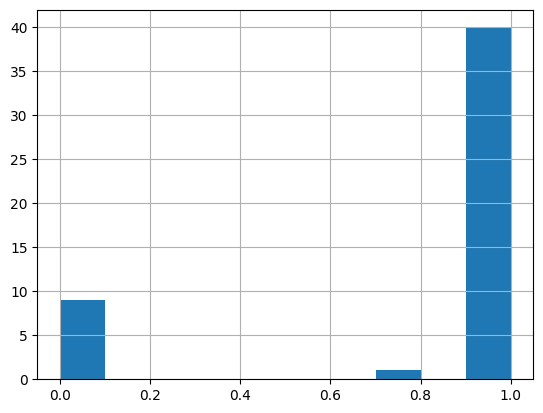

In [13]:
results.recall_retriever.hist()

In [15]:
(results.recall_llm == 1.0).mean()

0.68

LLM recall when retriever is right: 0.75


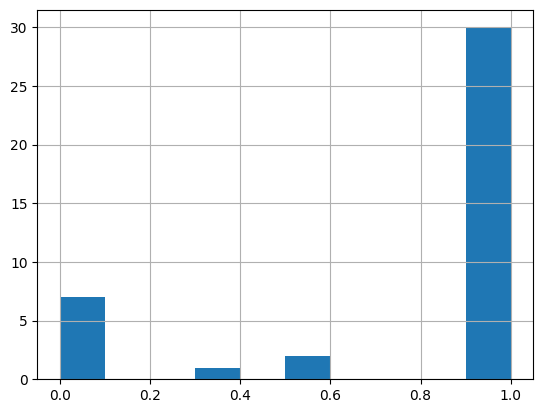

In [18]:
right_retriever = results.loc[results.recall_retriever == 1.0]
right_retriever.recall_llm.hist()
print(f"LLM recall when retriever is right: {(right_retriever.recall_llm == 1.0).mean()}")